In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer,InputSpec
from keras.layers import Input,Permute
from keras.layers import ConvLSTM2D
from keras.models import Model
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply
import tensorflow as tf
from keras import backend as K
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv1D, Input, Activation, AveragePooling2D, Add, Multiply, GlobalAveragePooling1D
from keras.models import Model
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.engine.topology import Layer,InputSpec

K.set_image_dim_ordering("th")


n_filters = 32
dilation_depth = 4
activation = 'softmax'
scale_ratio = 1
kernel_size = 3
pool_size_1 = 4
pool_size_2 = 8


def residual_block(x, i):
    print("processing : ",i)
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                      activation='tanh'
                      )(x)
    tanh_out=Dropout(0.15)(tanh_out)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                      activation='sigmoid'
                      )(x)
    sigm_out=Dropout(0.15)(sigm_out)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip


class WAVENETPARALLEL:
    @staticmethod
    def build(timeSteps, variables,classes):
        
        x = Input(shape=(timeSteps, variables), name='original_input')
        
        skip_connections = []

        #x2 = Conv2D(50, (2,3), strides = (1,3), padding='valid', name='dilated_conv_0')(x)
        #x2 =Reshape((127, 150))(x2)

        out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x)
        out=Dropout(0.15)(out)
        for i in range(1, dilation_depth + 1):
            out, skip = residual_block(out,i)
            skip_connections.append(skip)
        out = Add(name='skip_connections')(skip_connections)
        out = Activation('relu')(out)

        out = Conv1D(n_filters, pool_size_1, strides = 2, padding='valid', name='conv_5ms', activation = 'relu')(out)
        out=Dropout(0.05)(out)
        #out = AveragePooling1D(pool_size_1, padding='same', name='downsample_to_200Hz')(out)

        out = Conv1D(n_filters, pool_size_2, strides = 2,padding='valid', activation='relu', name='conv_500ms')(out)
        out=Dropout(0.15)(out)
        #out = Conv1D(output_shape[0], pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
        #out = AveragePooling1D(pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)

        out = Conv1D(classes, 3, strides = 2, padding='valid', name='final_conv')(out)
        out = GlobalAveragePooling1D(name='final_pooling')(out)
        out = Activation(activation, name='final_activation')(out)

        model = Model(x, out)  
        
        
        return model

/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rjpg/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [4]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size168-step24-Normalized.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size168-step24-norm.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,168,8))
#total_inputs = np.reshape(total_inputs, (-1,6,12,8)) #used for convLSTM2D

print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



############# total shapes #############
(1432, 168, 8)
1432
############# train shapes #############
(1146, 168, 8)
(1146, 1)
############# test shapes #############
(286, 168, 8)
(286, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [5]:

STEPS, VARS = 168, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = WAVENETPARALLEL.build(timeSteps=STEPS, variables=VARS,classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(286, 5)
processing :  1
processing :  2
processing :  3
processing :  4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 168, 8)       0                                            
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 168, 32)      544         original_input[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 168, 32)      0           dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_conv_3_tanh (Conv1D)    (None, 168, 32)      3104        dropout_1[0][0]                  
____________________________________

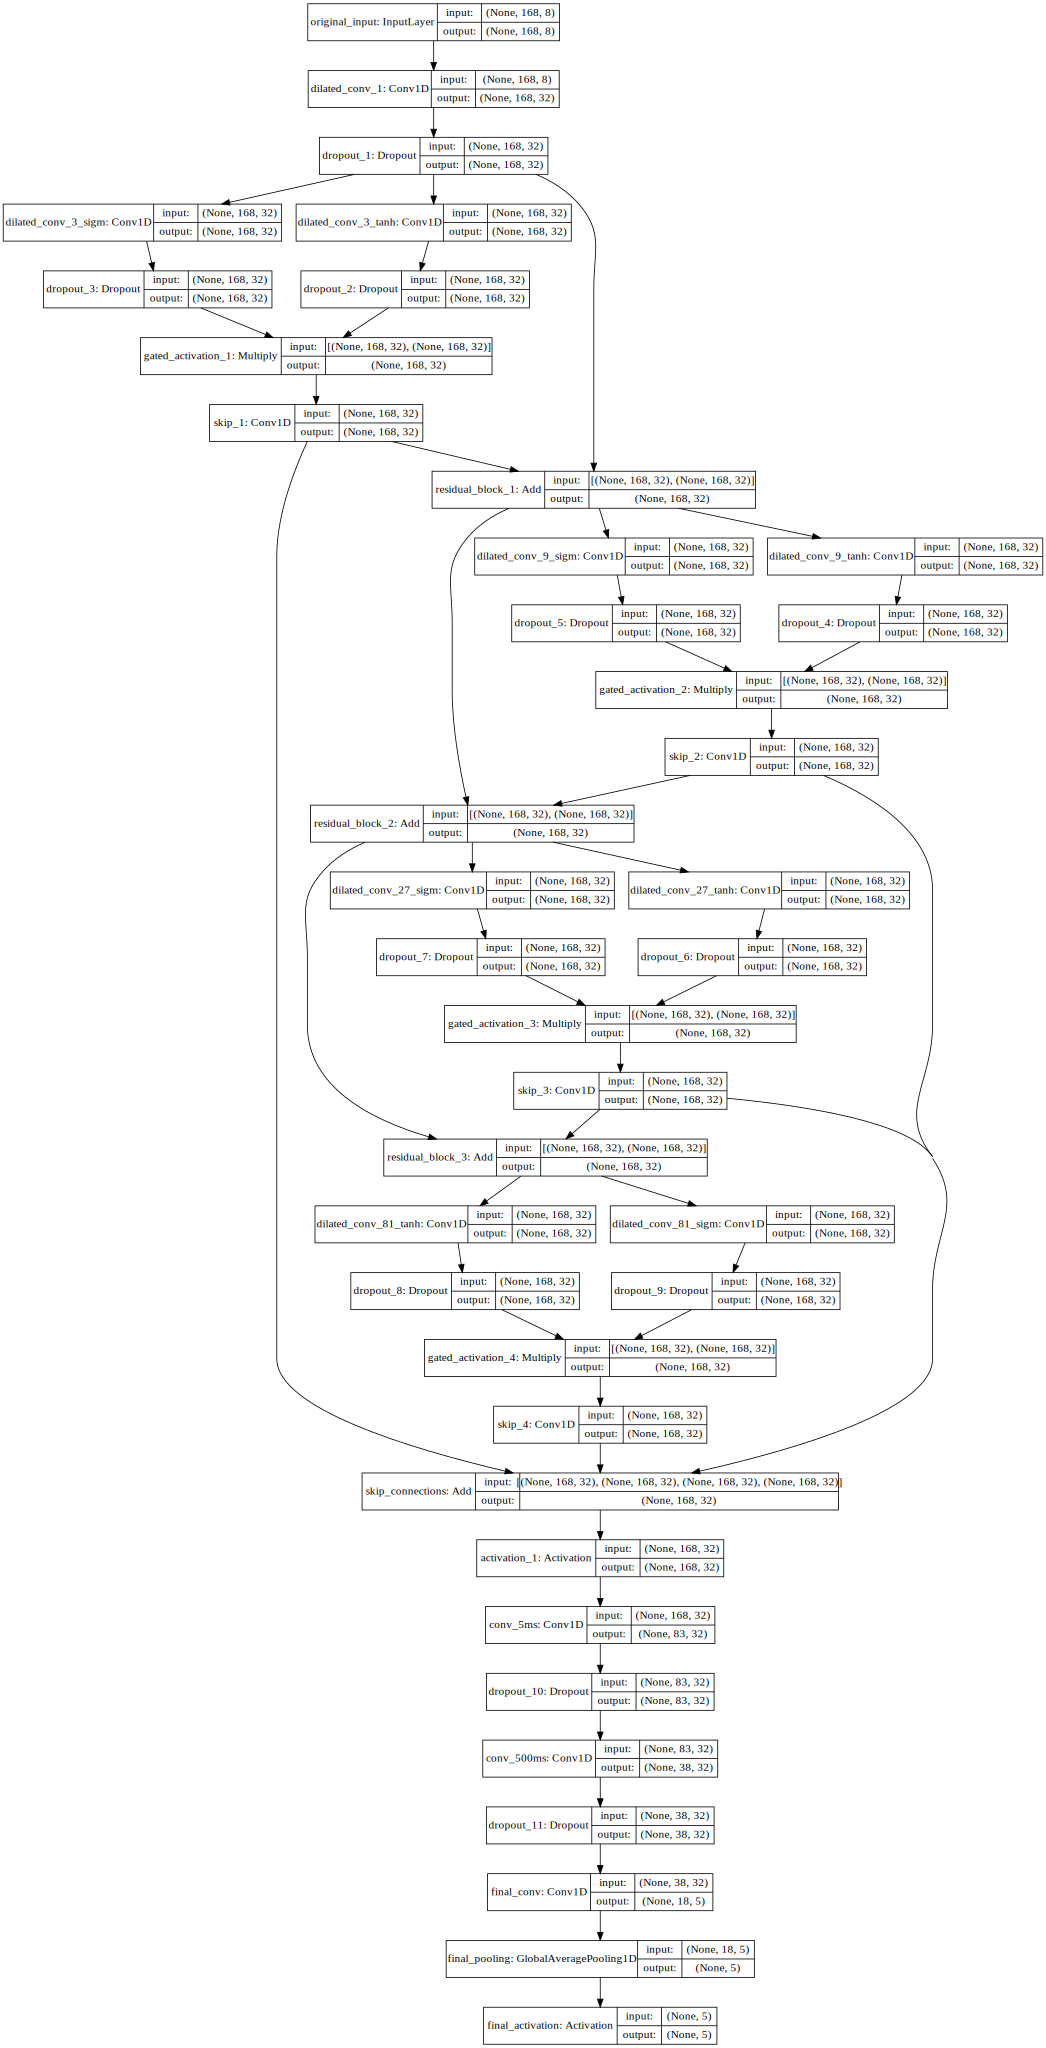

In [6]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [7]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('WAVENET-PARALLEL-enegie.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[best_checkpoint])

Train on 1146 samples, validate on 286 samples
Epoch 1/100
1146/1146 [==============================] - 4s 4ms/step - loss: 1.5779 - acc: 0.3028 - val_loss: 1.5208 - val_acc: 0.2238

Epoch 00001: val_acc improved from -inf to 0.22378, saving model to WAVENET-PARALLEL-enegie.h5
Epoch 2/100
1146/1146 [==============================] - 0s 380us/step - loss: 1.3808 - acc: 0.3857 - val_loss: 1.4574 - val_acc: 0.3042

Epoch 00002: val_acc improved from 0.22378 to 0.30420, saving model to WAVENET-PARALLEL-enegie.h5
Epoch 3/100
1146/1146 [==============================] - 0s 376us/step - loss: 1.3463 - acc: 0.4136 - val_loss: 1.4138 - val_acc: 0.3287

Epoch 00003: val_acc improved from 0.30420 to 0.32867, saving model to WAVENET-PARALLEL-enegie.h5
Epoch 4/100
1146/1146 [==============================] - 0s 386us/step - loss: 1.3290 - acc: 0.4110 - val_loss: 1.4545 - val_acc: 0.3427

Epoch 00004: val_acc improved from 0.32867 to 0.34266, saving model to WAVENET-PARALLEL-enegie.h5
Epoch 5/100
11


Epoch 00041: val_acc did not improve from 0.43357
Epoch 42/100
1146/1146 [==============================] - 0s 371us/step - loss: 1.0534 - acc: 0.5724 - val_loss: 1.4494 - val_acc: 0.3531

Epoch 00042: val_acc did not improve from 0.43357
Epoch 43/100
1146/1146 [==============================] - 0s 371us/step - loss: 1.0513 - acc: 0.5742 - val_loss: 1.4588 - val_acc: 0.3531

Epoch 00043: val_acc did not improve from 0.43357
Epoch 44/100
1146/1146 [==============================] - 0s 383us/step - loss: 1.0393 - acc: 0.5620 - val_loss: 1.4282 - val_acc: 0.3671

Epoch 00044: val_acc did not improve from 0.43357
Epoch 45/100
1146/1146 [==============================] - 0s 382us/step - loss: 1.0449 - acc: 0.5611 - val_loss: 1.3849 - val_acc: 0.3671

Epoch 00045: val_acc did not improve from 0.43357
Epoch 46/100
1146/1146 [==============================] - 0s 398us/step - loss: 1.0314 - acc: 0.5750 - val_loss: 1.4374 - val_acc: 0.3811

Epoch 00046: val_acc did not improve from 0.43357
Epoc

1146/1146 [==============================] - 0s 390us/step - loss: 0.7061 - acc: 0.7155 - val_loss: 1.8245 - val_acc: 0.3497

Epoch 00085: val_acc did not improve from 0.43357
Epoch 86/100
1146/1146 [==============================] - 0s 380us/step - loss: 0.7014 - acc: 0.7182 - val_loss: 1.8257 - val_acc: 0.3322

Epoch 00086: val_acc did not improve from 0.43357
Epoch 87/100
1146/1146 [==============================] - 0s 380us/step - loss: 0.6419 - acc: 0.7382 - val_loss: 1.8513 - val_acc: 0.3322

Epoch 00087: val_acc did not improve from 0.43357
Epoch 88/100
1146/1146 [==============================] - 0s 395us/step - loss: 0.6639 - acc: 0.7400 - val_loss: 1.9125 - val_acc: 0.3357

Epoch 00088: val_acc did not improve from 0.43357
Epoch 89/100
1146/1146 [==============================] - 0s 379us/step - loss: 0.7005 - acc: 0.7312 - val_loss: 1.8304 - val_acc: 0.3252

Epoch 00089: val_acc did not improve from 0.43357
Epoch 90/100
1146/1146 [==============================] - 0s 392us/s

In [8]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('WAVENET-PARALLEL-enegie.hist',history)
hist=loadHist('WAVENET-PARALLEL-enegie.hist')




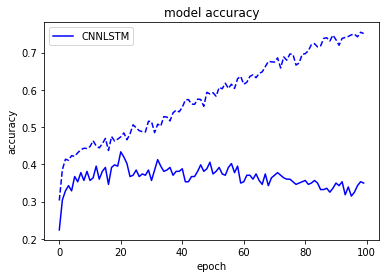

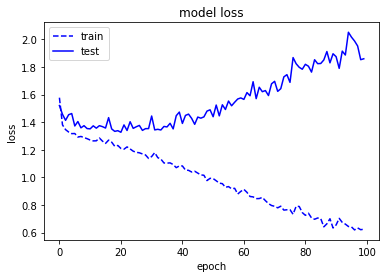

In [9]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='CNNLSTM')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
from keras.models import load_model
model = load_model('WAVENET-PARALLEL-enegie.h5')

In [11]:
from sklearn.metrics import classification_report, confusion_matrix


print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)


Confusion Matrix
[[30 19  0  4  2]
 [11 37 19  4  0]
 [ 3 23 36  5  6]
 [ 1 10 25 15  8]
 [ 2  2 10  8  6]]
Dados Validação acc: 43.36%
             precision    recall  f1-score   support

          0     0.6383    0.5455    0.5882        55
          1     0.4066    0.5211    0.4568        71
          2     0.4000    0.4932    0.4417        73
          3     0.4167    0.2542    0.3158        59
          4     0.2727    0.2143    0.2400        28

avg / total     0.4384    0.4336    0.4279       286



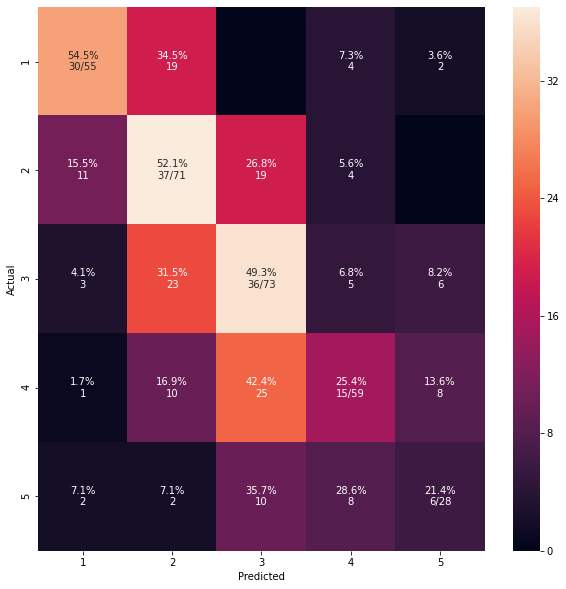

In [12]:
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("WAVENET-PARALLEL-enegie.pdf")
    plt.show()
    
    
    
cm_analysis(np.argmax(y_test,axis=1),np.argmax(pred,axis=1), labels=["1","2","3","4","5"], ymap=None, figsize=(10,10))
